In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import importlib

sys.path.append(os.path.abspath(".."))
import misc
importlib.reload(misc)
from misc import load_csv_dataset

In [5]:
df = pd.DataFrame(load_csv_dataset("names_featured.csv"))

>> Loading CSV dataset from names_featured.csv
>> Detected fieldnames: ['name', 'sex', 'region', 'year', 'words', 'length', 'probable_native', 'probable_surname', 'identified_category', 'identified_name', 'identified_surname', 'annotated', 'province']
>> Successfully loaded with UTF-8 encoding


## Breakdown by major province

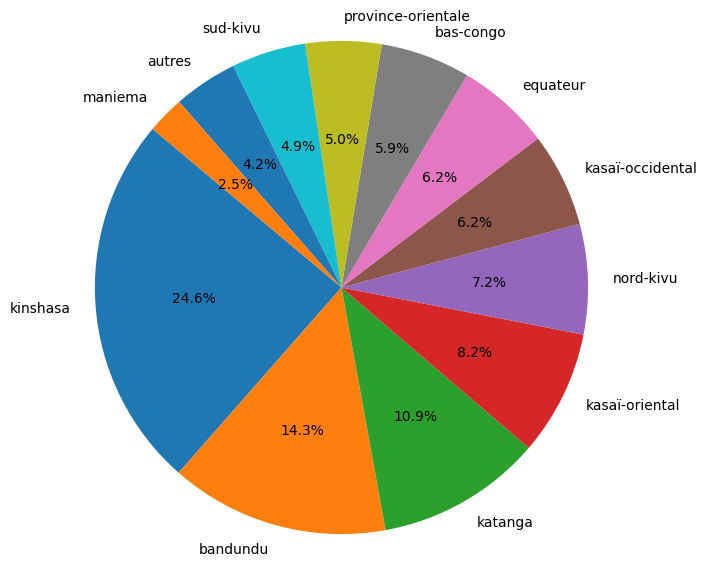

In [6]:
provinces = df['province'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(provinces, labels=provinces.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

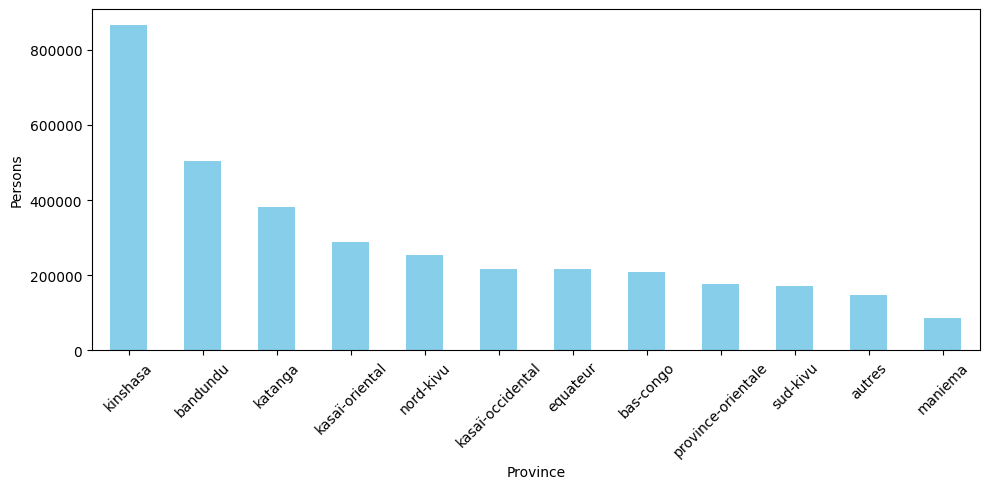

In [9]:
plt.figure(figsize=(10, 5))
provinces.plot(kind='bar', color='skyblue')
plt.xlabel("Province")
plt.ylabel("Persons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
#breakdown of names into surname, middle name and first name
#constraint: take into account compound names (eg. ILUNGA WA ILUNGA MARC)
#            take into account missing names (eg. LOKUA KANZA, KASONGO GERMAINE)

df['split'] = df['name'].str.strip().str.split()
df = df[df['split'].notna() & df['split'].str.len() > 0]
df['surname'] = df['split'].apply(lambda x: x[0] if len(x) >= 1 else "null")
df['first_name'] = df['split'].apply(lambda x: x[-1] if len(x) >= 2 else "null")
df['middle_name'] = df['split'].apply(lambda x: ' '.join(x[1:-1]) if len(x) > 2 else "null")
df.drop(columns=['split'], inplace=True)
df[['name', 'surname', 'middle_name', 'first_name']].head()

,name,surname,middle_name,first_name
0,dikoko pamitshefu fabrice,dikoko,pamitshefu,fabrice
1,epenge djongesongo jonas,epenge,djongesongo,jonas
2,eyongoyongo shako michel,eyongoyongo,shako,michel
3,kassongo osango israel,kassongo,osango,israel
4,okawonga ongondjo alphonse,okawonga,ongondjo,alphonse


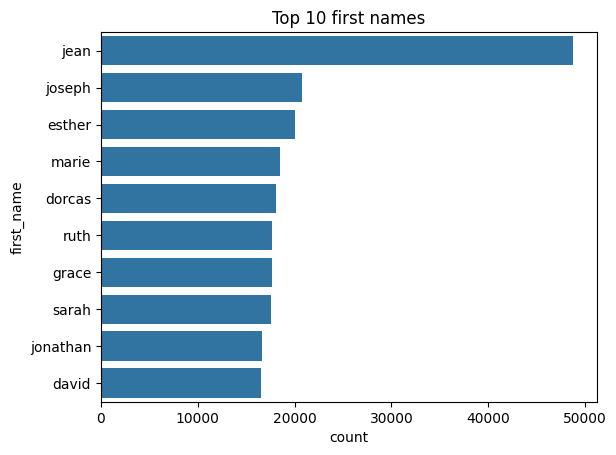

In [11]:
# Simple distribution of first names (display of the 10 most popular first names)
sns.countplot(y=df['first_name'], order=df['first_name'].value_counts().iloc[:10].index)
plt.title("Top 10 first names")
plt.show()

In [12]:
firstnames = df['first_name'].value_counts()
df_firstnames = firstnames.reset_index()
df_firstnames.columns = ['FIrst name', 'quantity']
df_firstnames.head(10)

,FIrst name,quantity
0,jean,48799
1,joseph,20818
2,esther,20048
3,marie,18523
4,dorcas,18066
5,ruth,17660
6,grace,17652
7,sarah,17533
8,jonathan,16592
9,david,16551


In [14]:
# Total number of distinct first names
total_firstnames = df['first_name'].notna().sum()
print(f">> Total number of first names registered : {total_firstnames}")

# categorization of first names
firstnames_by_sex = df.groupby(['first_name', 'sex']).size().unstack(fill_value=0)
male_firstnames = firstnames_by_sex[(firstnames_by_sex['m'] > 0) & (firstnames_by_sex['f'] == 0)]
print(f">> Number of all-male first names : {len(male_firstnames)}")
female_firstnames = firstnames_by_sex[(firstnames_by_sex['f'] > 0) & (firstnames_by_sex['m'] == 0)]
print(f">> Number of all-female first names : {len(female_firstnames)}")
neutral_firstnames = firstnames_by_sex[(firstnames_by_sex['m'] > 0) & (firstnames_by_sex['f'] > 0)]
print(f">> Number of all-neutral first names : {len(neutral_firstnames)}")


>> Total number of first names registered : 2754239
>> Number of all-male first names : 94503
>> Number of all-female first names : 55062
>> Number of all-neutral first names : 22516


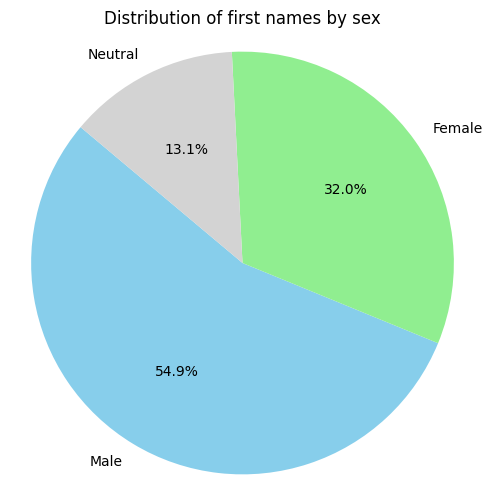

In [15]:
# data for graphic interpretation 
labels = ['Male', 'Female', 'Neutral']
values = [len(male_firstnames), len(female_firstnames), len(neutral_firstnames)]

# circular
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.axis('equal')
plt.show()

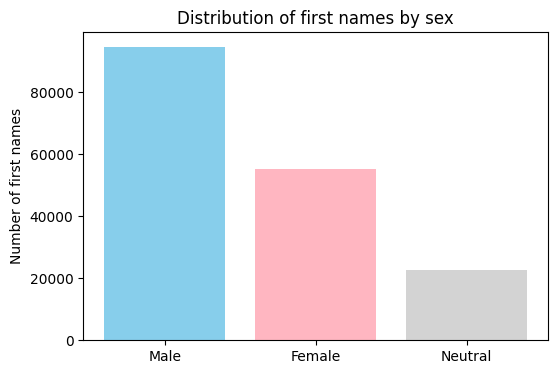

In [16]:
# Histogram
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['skyblue', 'lightpink', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.ylabel("Number of first names")
plt.show()

In [17]:
# Count of unique first names per region (province)
distinct_regions = df['province'].nunique()
print(f">> Number of distinct regions: {distinct_regions}")
firstnames_by_region = df.groupby('province')['first_name'].nunique().sort_values(ascending=False)

print("Number of unique first names per region")
df_firstnames_region = firstnames_by_region.reset_index()
df_firstnames_region.columns = ['Region', 'Unique first names']
df_firstnames_region.head(12)


>> Number of distinct regions: 12
Number of unique first names per region


,Region,Unique first names
0,kinshasa,73988
1,bandundu,39558
2,katanga,32774
3,nord-kivu,23873
4,bas-congo,23373
5,autres,18737
6,equateur,18604
7,sud-kivu,14758
8,province-orientale,14504
9,kasaï-oriental,14114


In [18]:
# top 3 most popular first names by region
grouped = df.groupby(['province', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['province', 'count'], ascending=[True, False])
top3_by_region = grouped.groupby('province').head(3)

for province, group in top3_by_region.groupby('province'):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()


AUTRES
    jean            1986
    patrick         1223
    tresor          1185

BANDUNDU
    jean            4028
    joel            1248
    tresor          975

BAS-CONGO
    jean            3287
    joseph          2041
    marie           1765

EQUATEUR
    jean            6439
    joseph          2372
    marie           1918

KASAÏ-OCCIDENTAL
    jean            7704
    andre           3595
    marie           2562

KASAÏ-ORIENTAL
    jean            11827
    joseph          4332
    marie           3898

KATANGA
    jean            4257
    ruth            2475
    esther          2342

KINSHASA
    sarah           9554
    dorcas          9494
    ruth            9482

MANIEMA
    jean            1042
    joseph          566
    marie           479

NORD-KIVU
    justin          2555
    grace           2439
    moise           2309

PROVINCE-ORIENTALE
    jean            3035
    moise           1826
    joseph          1729

SUD-KIVU
    justin          1397
    jean   

In [19]:
#Group by region, gender and first name, then count
def determine_sex_category(row):
    if row['first_name'] in neutral_firstnames:
        return 'Neutral'
    return row['sex']

df['sex_category'] = df.apply(determine_sex_category, axis=1)

# Groupement
grouped = df.groupby(['province', 'sex_category', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['province', 'sex_category', 'count'], ascending=[True, True, False])
top3_by_region_sex = grouped.groupby(['province', 'sex_category']).head(3)

for (province, sex), group in top3_by_region_sex.groupby(['province', 'sex_category']):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()


AUTRES - Neutral
    m               24
    f               3

AUTRES - f
    gracia          723
    marie           519
    christelle      393

AUTRES - m
    jean            1984
    patrick         1219
    tresor          1179

BANDUNDU - Neutral
    m               68
    f               31

BANDUNDU - f
    marie           848
    esther          797
    ruth            725

BANDUNDU - m
    jean            4003
    joel            1206
    tresor          969

BAS-CONGO - Neutral
    f               2
    m               2

BAS-CONGO - f
    marie           1750
    dorcas          1295
    esther          1116

BAS-CONGO - m
    jean            3277
    joseph          2035
    andre           1108

EQUATEUR - Neutral
    m               7
    f               2

EQUATEUR - f
    marie           1878
    esther          1424
    ruth            1032

EQUATEUR - m
    jean            6411
    joseph          2364
    jeremie         1691

KASAÏ-OCCIDENTAL - Neutral
    m       

In [20]:
# Grouping surnames by sex
surnames_by_sex = df.groupby(['surname', 'sex']).size().reset_index(name='count')
surnames_by_sex = surnames_by_sex.sort_values(['sex', 'count'], ascending=[True, False])
top10_per_sex = surnames_by_sex.groupby('sex').head(10)

for sex, group in top10_per_sex.groupby('sex'):
    print(f"Top 10 surnames for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()



Top 10 surnames for sex: f
    kavira          14338
    kavugho         8670
    kahindo         8644
    ntumba          7519
    mbuyi           6889
    ngalula         6792
    ilunga          6787
    kapinga         6486
    mujinga         6465
    masika          6297

Top 10 surnames for sex: m
    ilunga          18801
    kambale         14270
    kasongo         13358
    ngoy            12646
    kasereka        10052
    muhindo         8945
    kazadi          7804
    mutombo         7371
    ngoyi           7312
    mumbere         7052



In [21]:
# Grouping surnames by region
surnames_by_region = df.groupby(['province', 'surname']).size().reset_index(name='count')
surnames_by_region = surnames_by_region.sort_values(['province', 'count'], ascending=[True, False])
top3_surnames_per_region = surnames_by_region.groupby('province').head(3)

for province, group in top3_surnames_per_region.groupby('province'):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()


AUTRES
    ilunga          4432
    ngoy            3649
    kasongo         2574

BANDUNDU
    mbo             3165
    mpia            2143
    mputu           1573

BAS-CONGO
    nzuzi           3691
    nlandu          3091
    matondo         2655

EQUATEUR
    mboyo           1403
    lokuli          796
    bolumbu         641

KASAÏ-OCCIDENTAL
    ntumba          3578
    mbuyi           3151
    kanku           2117

KASAÏ-ORIENTAL
    ngoyi           7652
    ilunga          4360
    kasongo         3628

KATANGA
    ilunga          12442
    ngoy            10448
    kasongo         7967

KINSHASA
    ntumba          4610
    nsimba          4291
    matondo         4151

MANIEMA
    amisi           860
    ramazani        732
    assani          577

NORD-KIVU
    kavira          13455
    kambale         13371
    kasereka        9503

PROVINCE-ORIENTALE
    bahati          814
    baraka          644
    kambale         634

SUD-KIVU
    bahati          1338
    furaha   

In [22]:
# Grouping surnames by region and sex
grouped = df.groupby(['province', 'sex', 'surname']).size().reset_index(name='count')
grouped = grouped.sort_values(['province', 'sex', 'count'], ascending=[True, True, False])
top3_surnames_by_region_sex = grouped.groupby(['province', 'sex']).head(3)

for (province, sex), group in top3_surnames_by_region_sex.groupby(['province', 'sex']):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

AUTRES - f
    ilunga          1035
    ngoy            579
    ngoie           567

AUTRES - m
    ilunga          3397
    ngoy            3070
    kasongo         2026

BANDUNDU - f
    mbo             1064
    mpia            757
    mputu           578

BANDUNDU - m
    mbo             2101
    mpia            1386
    mputu           995

BAS-CONGO - f
    nzuzi           1995
    nlandu          1431
    tsimba          1424

BAS-CONGO - m
    nzuzi           1696
    nlandu          1660
    ngoma           1653

EQUATEUR - f
    mboyo           670
    bolumbu         491
    amba            385

EQUATEUR - m
    mboyo           733
    lokuli          641
    lokwa           389

KASAÏ-OCCIDENTAL - f
    ngalula         1983
    kapinga         1187
    mbuyi           1105

KASAÏ-OCCIDENTAL - m
    ntumba          2485
    mbuyi           2046
    ngalamulume     2034

KASAÏ-ORIENTAL - f
    ngoyi           1786
    ntumba          1580
    mbuyi           1515

KASAÏ-ORIENT

In [24]:
# Find surnames common to both sexes per region - the most popular per region

common_surnames = df.groupby(['province', 'surname', 'sex']).size().unstack(fill_value=0)
common_surnames = common_surnames[(common_surnames.get('m', 0) > 0) & (common_surnames.get('f', 0) > 0)]
common_surnames['total'] = common_surnames['m'] + common_surnames['f']
common_surnames = common_surnames.reset_index()
top_common_surnames = common_surnames.sort_values(['province', 'total'], ascending=[True, False])
top_common_surnames = top_common_surnames.groupby('province').first().reset_index()

for _, row in top_common_surnames.iterrows():
    print(f"{row['province'].upper()} → {row['surname']} ({row['m']} M / {row['f']} F) - Total: {row['total']}")

AUTRES → ilunga (3397 M / 1035 F) - Total: 4432
BANDUNDU → mbo (2101 M / 1064 F) - Total: 3165
BAS-CONGO → nzuzi (1696 M / 1995 F) - Total: 3691
EQUATEUR → mboyo (733 M / 670 F) - Total: 1403
KASAÏ-OCCIDENTAL → ntumba (2485 M / 1093 F) - Total: 3578
KASAÏ-ORIENTAL → ngoyi (5866 M / 1786 F) - Total: 7652
KATANGA → ilunga (8149 M / 4293 F) - Total: 12442
KINSHASA → ntumba (1475 M / 3135 F) - Total: 4610
MANIEMA → amisi (732 M / 128 F) - Total: 860
NORD-KIVU → kavira (46 M / 13409 F) - Total: 13455
PROVINCE-ORIENTALE → bahati (649 M / 165 F) - Total: 814
SUD-KIVU → bahati (1015 M / 323 F) - Total: 1338


In [25]:
# Grouping middle names by sex
middlenames_by_sex = df.groupby(['middle_name', 'sex']).size().reset_index(name='count')
middlenames_by_sex = middlenames_by_sex.sort_values(['sex', 'count'], ascending=[True, False])
top10_middlenames_per_sex = middlenames_by_sex.groupby('sex').head(10)

for sex, group in top10_middlenames_per_sex.groupby('sex'):
    print(f"Top 10 middle names for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<15} {row['count']}")
    print()


Top 10 middle names for sex: f
    ilunga          7014
    kasongo         5443
    kazadi          4379
    ngoy            4126
    ntumba          4078
    mutombo         3858
    ngoyi           3354
    matondo         3268
    kabeya          3115
    mukendi         3064

Top 10 middle names for sex: m
    ilunga          12015
    kasongo         9341
    ngoy            8166
    kazadi          7070
    mutombo         6953
    ngoyi           6742
    ntumba          5687
    wa              5146
    kabeya          5034
    mukendi         4881



In [26]:
# Grouping middle names by region
middlenames_by_region = df.groupby(['province', 'middle_name']).size().reset_index(name='count')
middlenames_by_region = middlenames_by_region.sort_values(['province', 'count'], ascending=[True, False])
top3_middlenames_per_region = middlenames_by_region.groupby('province').head(3)

for province, group in top3_middlenames_per_region.groupby('province'):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['count']}")
    print()    

AUTRES
    ngoy                 2177
    ilunga               2129
    kasongo              1583

BANDUNDU
    moke                 1856
    mbo                  1241
    n                    1132

BAS-CONGO
    ngoma                3512
    nlandu               2052
    khonde               1681

EQUATEUR
    mboyo                962
    lokuli               950
    lokwa                606

KASAÏ-OCCIDENTAL
    ntumba               3272
    muamba               2137
    mulumba              1621

KASAÏ-ORIENTAL
    ngoyi                7868
    ilunga               5293
    kasongo              4395

KATANGA
    ilunga               6631
    ngoy                 6551
    wa                   5153

KINSHASA
    matondo              3853
    ntumba               3136
    ilunga               3030

MANIEMA
    ramazani             706
    amisi                535
    shabani              461

NORD-KIVU
    tsongo               1337
    bahati               1095
    mahamba              

In [27]:
# Grouping middle names by province and sex
middlenames_by_province_sex = df.groupby(['province', 'sex', 'middle_name']).size().reset_index(name='count')
middlenames_by_province_sex = middlenames_by_province_sex.sort_values(['province', 'sex', 'count'], ascending=[True, True, False])
top3_middlenames_by_province_sex = middlenames_by_province_sex.groupby(['province', 'sex']).head(3)

for (province, sex), group in top3_middlenames_by_province_sex.groupby(['province', 'sex']):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['count']}")
    print()

AUTRES - f
    ilunga               692
    kasongo              517
    ngoy                 470

AUTRES - m
    ngoy                 1707
    ilunga               1437
    kasongo              1066

BANDUNDU - f
    modiri               578
    mbo                  497
    mpia                 451

BANDUNDU - m
    moke                 1625
    n                    802
    mbo                  744

BAS-CONGO - f
    ngoma                1539
    nlandu               930
    khonde               749

BAS-CONGO - m
    ngoma                1973
    nlandu               1122
    muanda               963

EQUATEUR - f
    mboyo                349
    lokuli               322
    lokwa                190

EQUATEUR - m
    lokuli               628
    mboyo                613
    nkoy                 419

KASAÏ-OCCIDENTAL - f
    ntumba               805
    muamba               491
    mulumba              431

KASAÏ-OCCIDENTAL - m
    ntumba               2467
    muamba               16

In [29]:
# Find middle names common to both sexes per region
common_middlenames = df.groupby(['province', 'middle_name', 'sex']).size().unstack(fill_value=0)
common_middlenames = common_middlenames[(common_middlenames.get('m', 0) > 0) & (common_middlenames.get('f', 0) > 0)]
common_middlenames['total'] = common_middlenames['m'] + common_middlenames['f']
common_middlenames = common_middlenames.reset_index()
common_middlenames = common_middlenames.sort_values(['province', 'total'], ascending=[True, False])
top3_common_middlenames = common_middlenames.groupby('province').head(3)

for province, group in top3_common_middlenames.groupby('province'):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['total']}")
    print()


AUTRES
    ngoy                 2177
    ilunga               2129
    kasongo              1583

BANDUNDU
    moke                 1856
    mbo                  1241
    n                    1132

BAS-CONGO
    ngoma                3512
    nlandu               2052
    khonde               1681

EQUATEUR
    mboyo                962
    lokuli               950
    lokwa                606

KASAÏ-OCCIDENTAL
    ntumba               3272
    muamba               2137
    mulumba              1621

KASAÏ-ORIENTAL
    ngoyi                7868
    ilunga               5293
    kasongo              4395

KATANGA
    ilunga               6631
    ngoy                 6551
    wa                   5153

KINSHASA
    matondo              3853
    ntumba               3136
    ilunga               3030

MANIEMA
    ramazani             706
    amisi                535
    shabani              461

NORD-KIVU
    tsongo               1337
    bahati               1095
    mahamba              

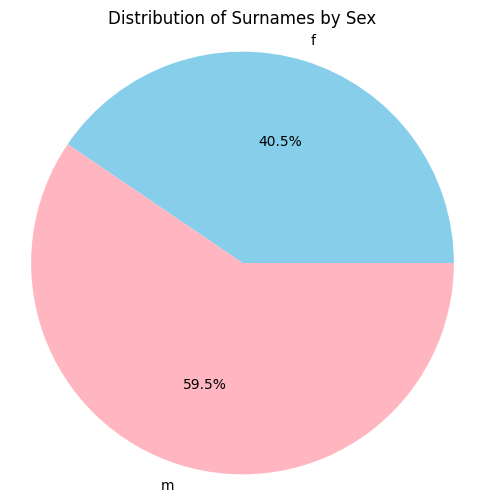

In [30]:
# Pie chart of surnames by sex
surnames_sex_count = surnames_by_sex.groupby('sex')['count'].sum()
plt.figure(figsize=(6,6))
plt.pie(surnames_sex_count, labels=surnames_sex_count.index, autopct='%1.1f%%', colors=['skyblue', 'lightpink'])
plt.title("Distribution of Surnames by Sex")
plt.axis('equal')
plt.show()


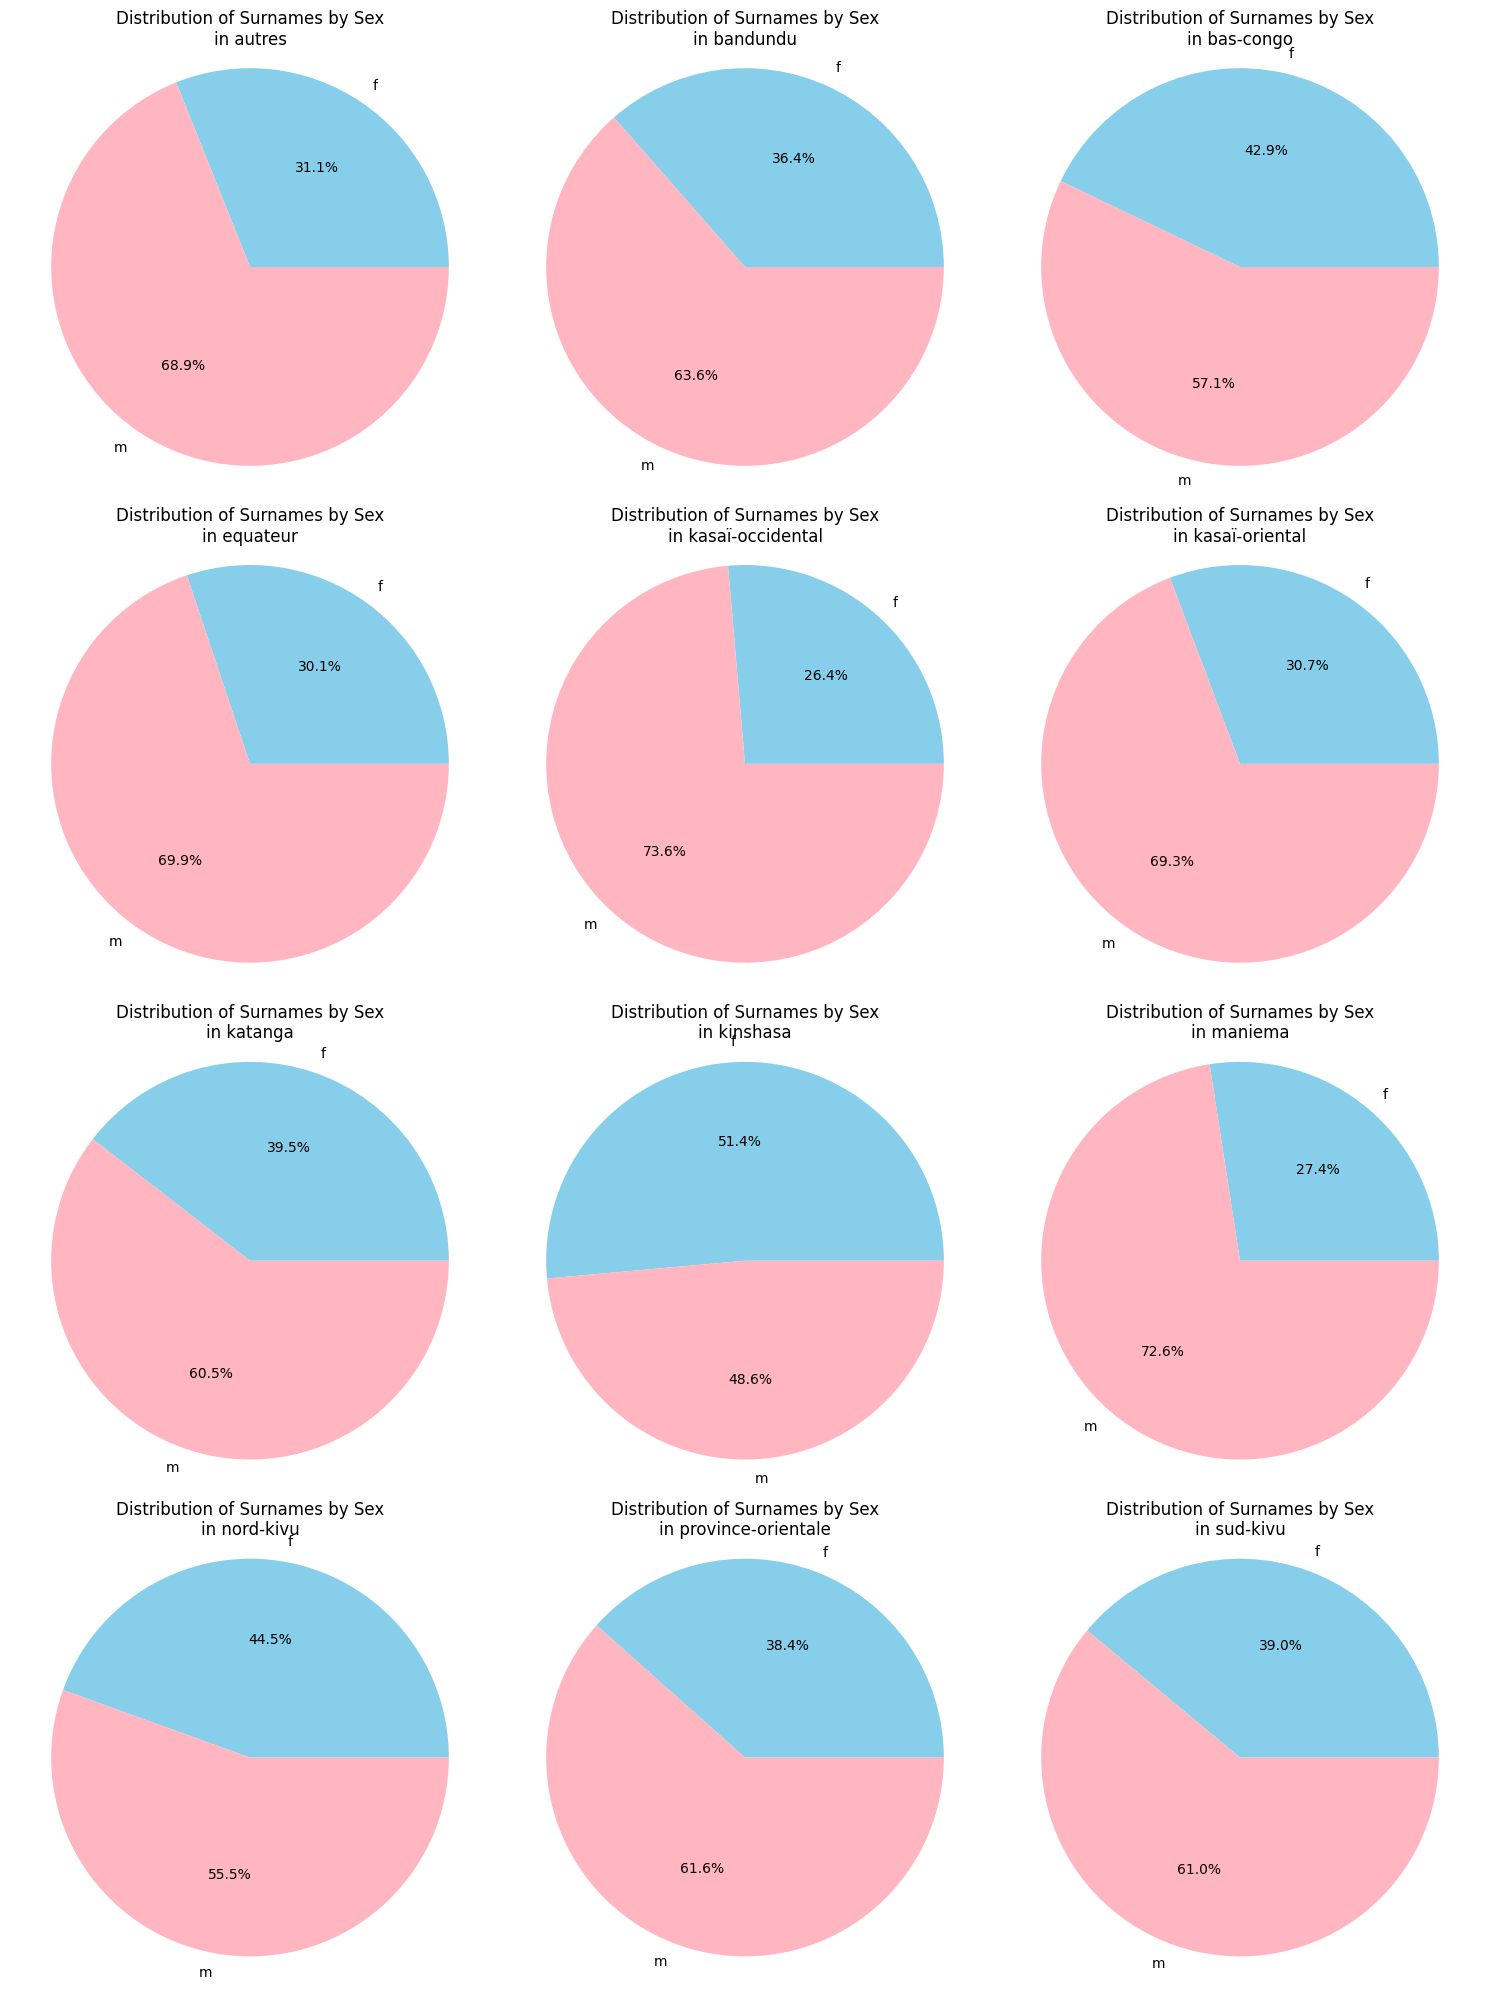

In [31]:
# Pie chart of surnames bu sex and region
prov_sex_counts = df.groupby(['province', 'sex']).size().reset_index(name='count')
provinces = prov_sex_counts['province'].unique()
cols = 3
rows = (len(provinces) + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 5))
for i, prov in enumerate(provinces, 1):
    data = prov_sex_counts[prov_sex_counts['province'] == prov]
    plt.subplot(rows, cols, i)
    plt.pie(data['count'], labels=data['sex'], autopct='%1.1f%%', colors=['skyblue', 'lightpink'])
    plt.title(f"Distribution of Surnames by Sex\nin {prov}")
    plt.axis('equal')

plt.tight_layout()
plt.show()

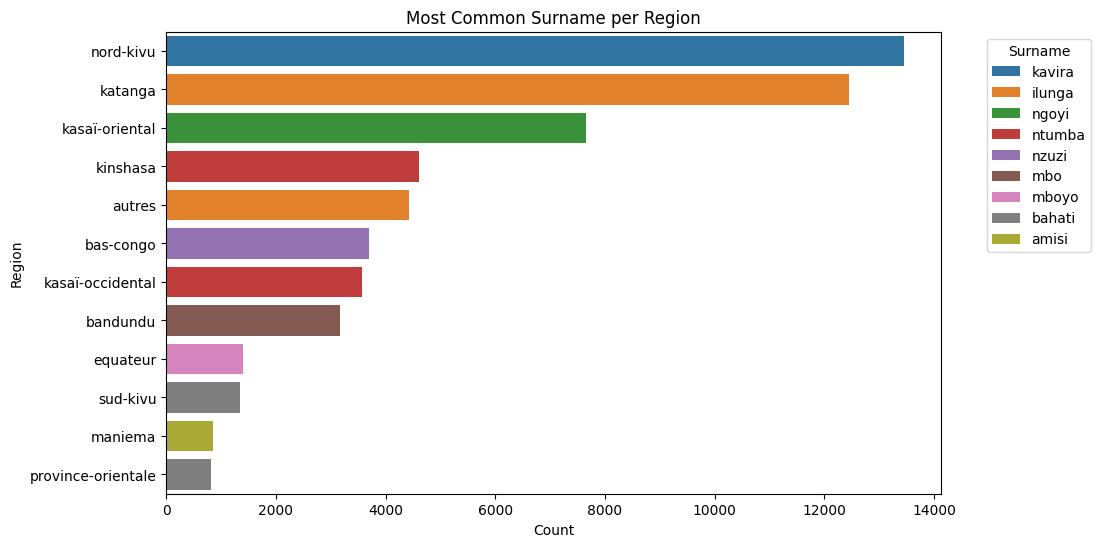

In [32]:
# surnames per region (aggregated)
top_surnames_region = surnames_by_region.sort_values('count', ascending=False).drop_duplicates('province').head(12)
plt.figure(figsize=(10,6))
sns.barplot(y='province', x='count', data=top_surnames_region, hue='surname', dodge=False)
plt.title("Most Common Surname per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Surname", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

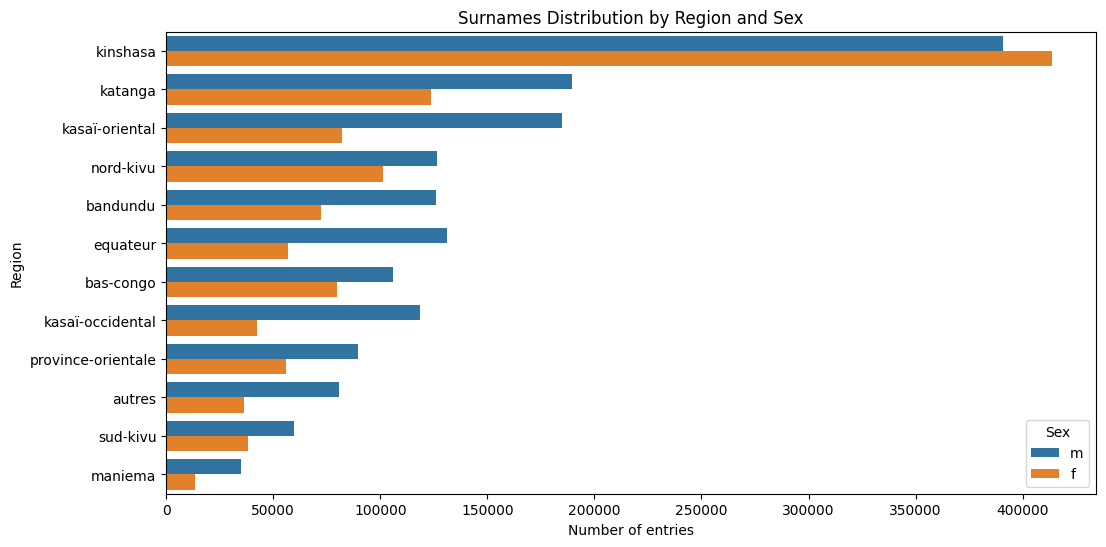

In [33]:
# Bar chart surnames by region and sex
top10_regions = df['province'].value_counts().head(12).index.tolist()
df_top10 = df[df['province'].isin(top10_regions)]
plt.figure(figsize=(12,6))
sns.countplot(data=df_top10, y='province', hue='sex', order=top10_regions)
plt.title("Surnames Distribution by Region and Sex")
plt.xlabel("Number of entries")
plt.ylabel("Region")
plt.legend(title='Sex')
plt.show()

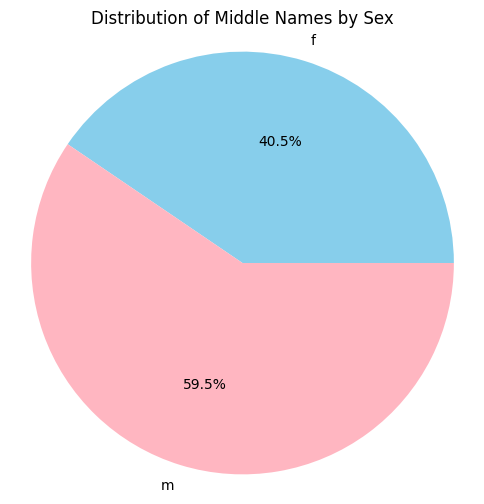

In [34]:
# Pie chart of middle names by sex
middlenames_sex_count = middlenames_by_province_sex.groupby('sex')['count'].sum()
plt.figure(figsize=(6,6))
plt.pie(middlenames_sex_count, labels=middlenames_sex_count.index, autopct='%1.1f%%', colors=['skyblue', 'lightpink'])
plt.title("Distribution of Middle Names by Sex")
plt.axis('equal')
plt.show()

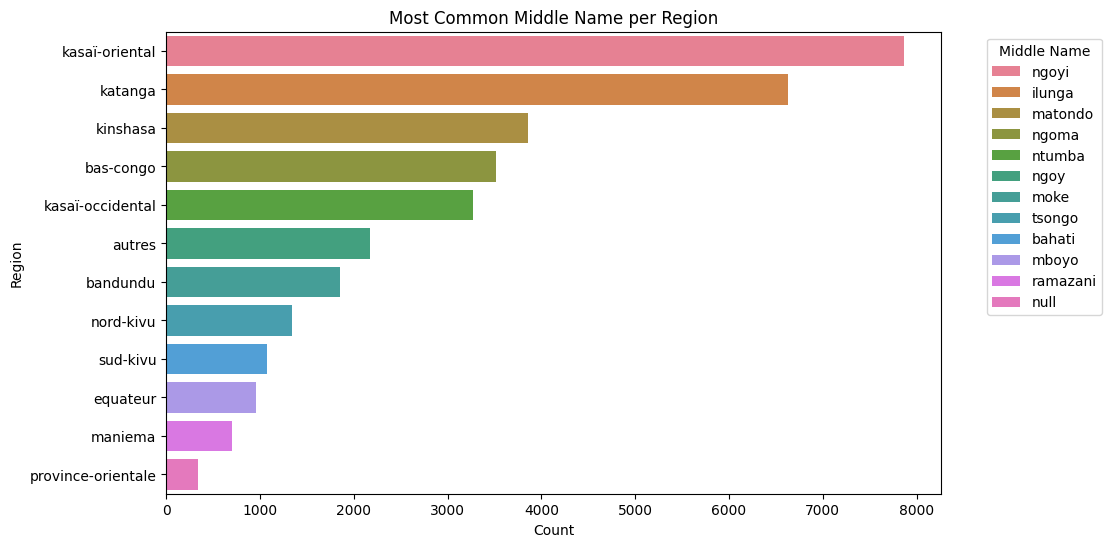

In [35]:
# most popular middle name per region
top_middlename_region = middlenames_by_region.sort_values('count', ascending=False).drop_duplicates('province').head(12)
plt.figure(figsize=(10,6))
sns.barplot(y='province', x='count', data=top_middlename_region, hue='middle_name', dodge=False)
plt.title("Most Common Middle Name per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Middle Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

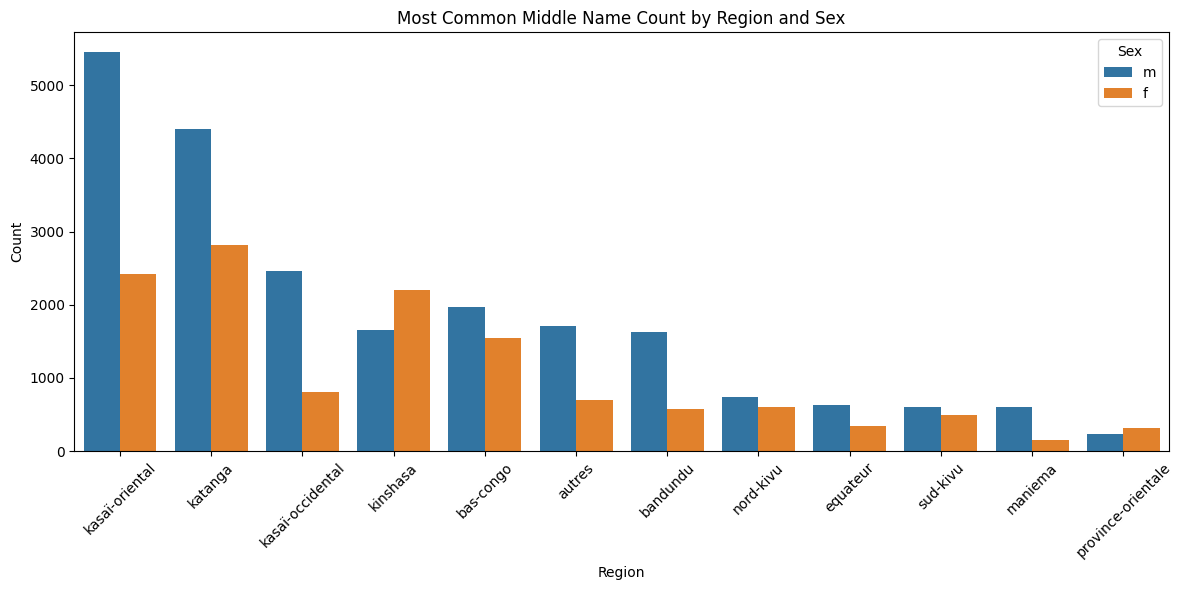

In [36]:
#Bar chart middle name by region and sex
middlenames_by_sex_region = df.groupby(['province', 'sex', 'middle_name']).size().reset_index(name='count')
top_middlename_sex_region = middlenames_by_sex_region.sort_values('count', ascending=False).drop_duplicates(['province', 'sex'])

# Bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_middlename_sex_region,
    x='province',
    y='count',
    hue='sex'
)
plt.title("Most Common Middle Name Count by Region and Sex")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()